In [ ]:
goog = False
if goog:
  from google.colab import drive
  drive.mount("/content/drive")
  base = "/content/drive/MyDrive/LoanApprovalPrediction/"
else:
  base = "0.Practice/Hotel_rating/"

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = pd.read_csv(base + "train.csv")
y = X.pop("loan_status")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state = 42)

X_test = pd.read_csv( base + "test.csv")

categorical_cols = [col for col in X.columns if X[col].dtype == "object"]
num_cols = [col for col in X.columns if X[col].dtype in  [ "float64", "int64"]]
print(len(num_cols), len(categorical_cols))

8 4


0        0
1        0
2        0
3        0
4        0
        ..
58640    0
58641    1
58642    1
58643    0
58644    0
Name: loan_status, Length: 58645, dtype: int64

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols), ('num', StandardScaler(), num_cols)])

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', SVC())
                             ])

In [ ]:
my_pipeline.fit(X_train, y_train)
print("baseline:", roc_auc_score(my_pipeline.predict(X_valid), y_valid))

In [ ]:
X_test["loan_status"] = my_pipeline.predict(X_test)

X_test[["id", "loan_status"]].to_csv(base + "SVC_prediction.csv", index = False)

In [ ]:
#valid base line = 0.93


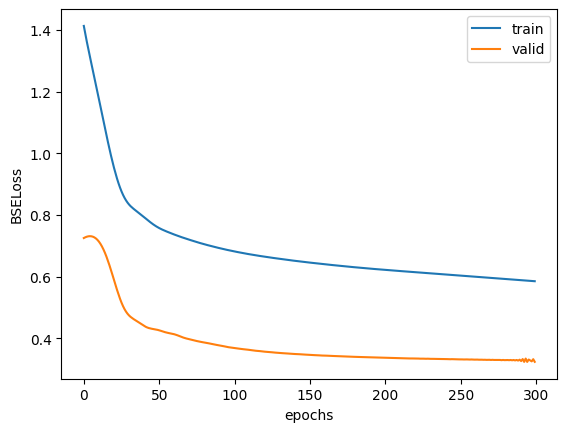

In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

class FeedForwardNN(nn.Module):
  def __init__(self, in_features, hiden_layer = 128):
    super().__init__()
    self.ffn = nn.Sequential(nn.Linear(in_features, hiden_layer), nn.ReLU(), nn.Linear(hiden_layer, hiden_layer), nn.ReLU())
    self.head = nn.Sequential(nn.Linear(in_features + hiden_layer, 1), nn.Sigmoid())
  def forward(self,x):
    return torch.squeeze(self.head(torch.concat([x, self.ffn(x)], axis=1)))
X_train_tens = torch.tensor(preprocessor.fit_transform(X_train)).float()
y_train_tens = torch.tensor(y_train.values).float()
X_valid_tens = torch.tensor(preprocessor.transform(X_valid)).float()
y_valid_tens = torch.tensor(y_valid.values).float()


model = FeedForwardNN(X_train_tens.shape[1])
optimizer = Adam(model.parameters(), lr = 0.001)




train_stats = []
valid_stats = []
epochs = []
pos_weight = torch.tensor([8.0])  # Weight for the positive class
neg_weight = torch.tensor([1.0])  # Weight for the negative class

weights = torch.where(y_train_tens == 1, pos_weight, neg_weight)
for epoch in range(300):
  loss_fn = BCELoss( weight = weights)
  model.train()
  optimizer.zero_grad()
  loss = loss_fn(model(X_train_tens), y_train_tens)
  loss.backward()
  optimizer.step()



  loss_fn = BCELoss()
  train_stats.append(loss.item())
  model.eval()
  with torch.no_grad():
    loss = loss_fn(model(X_valid_tens), y_valid_tens)
    valid_stats.append(loss.item())
  epochs.append(epoch)

plt.plot(epochs, train_stats, label="train")
plt.plot(epochs, valid_stats, label="valid")
plt.xlabel("epochs")
plt.ylabel("BSELoss")
plt.legend()
plt.show()




In [ ]:
X_test_tens = torch.tensor(preprocessor.fit_transform(X_test)).float()
with torch.no_grad():
  y_test_tens = model(X_test_tens)
X_test["loan_status"] = y_test_tens
X_test[["id", "loan_status"]].to_csv(base + "NN_prediction.csv", index = False)